In [1]:
import torch
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
import random
import os

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from image_loader.Image2numpy import convert_tiff_to_numpy


In [24]:
def plot_multi_channel_img(img):
    dims = img.shape[3]

    # Create example images (replace this with your own images)
    image1 = np.random.random((100, 100))  # Example grayscale image
    image2 = np.random.random((100, 100, 3))  # Example RGB image

    # Create a figure with subplots
    fig, axes = plt.subplots(1, dims, figsize=(10, 5*(dims-1)))  # 1 row, 2 columns

    for ii in range(dims):
        # Plot the images on the subplots
        axes[ii].imshow(np.max(img[:,:,:,ii],axis=2), cmap='gray')
        axes[ii].set_title("Ch "+str(ii))
        axes[ii].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

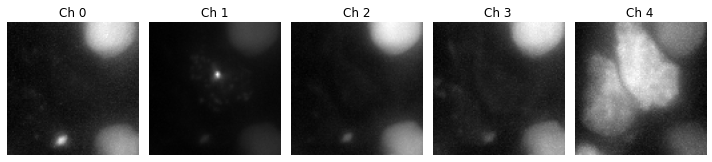

In [25]:
img = convert_tiff_to_numpy("/Users/talbarkai/Documents/PhD/Courses/PracticalDeepLearning/smfish_spot_detection/images/tagged_images/img1/image.tif")
plot_multi_channel_img(img)

In [30]:
Z_SPACER = 2
CHANNELS_FOR_CONV = [0,1,2]
img3d = img[:, :, Z_SPACER:-Z_SPACER, CHANNELS_FOR_CONV].copy()
img3d.shape

(100, 99, 6, 3)

In [31]:
img_t = torch.FloatTensor(img)


In [32]:
# inspired by https://towardsdatascience.com/pytorch-step-by-step-implementation-3d-convolution-neural-network-8bf38c70e8b3

num_classes = 2

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.max_pool = nn.MaxPool3d((2,2,2))
        self.fc1 = nn.Linear(2**3*64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        # nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [33]:
# Create CNN
model = CNNModel()
#model.cuda()
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (max_pool): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.15, inplace=False)
)


In [38]:
model(img_t)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3, 3], expected input[1, 100, 99, 10, 5] to have 3 channels, but got 100 channels instead

In [ ]:
#Definition of hyperparameters
n_iters = 4500
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)



# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)